Aggregating is the act of collecting something together and is a cornerstone of big data analytics.
In an aggregation, you will specify a key or grouping and an aggregation function that specifies
how you should transform one or more columns. This function must produce one result for each
group, given multiple input values. Spark’s aggregation capabilities are sophisticated and mature,
with a variety of different use cases and possibilities.

In addition to working with any type of values, Spark also allows us to create the following
groupings types:
1. The simplest grouping is to just summarize a complete DataFrame by performing an
aggregation in a select statement.
2. A “group by” allows you to specify one or more keys as well as one or more
aggregation functions to transform the value columns.
3. A “window” gives you the ability to specify one or more keys as well as one or more
aggregation functions to transform the value columns. However, the rows input to the
function are somehow related to the current row.
4. A “grouping set,” which you can use to aggregate at multiple different levels. Grouping
sets are available as a primitive in SQL and via rollups and cubes in DataFrames.
5. A “rollup” makes it possible for you to specify one or more keys as well as one or more
aggregation functions to transform the value columns, which will be summarized
hierarchically.
6. A “cube” allows you to specify one or more keys as well as one or more aggregation
functions to transform the value columns, which will be summarized across all
combinations of columns.

Each grouping returns a RelationalGroupedDataset on which we specify our aggregations.

# NOTE
An important thing to consider is how exact you need an answer to be. When performing calculations
over big data, it can be quite expensive to get an exact answer to a question, and it’s often much
cheaper to simply request an approximate to a reasonable degree of accuracy. You’ll note that we
mention some approximation functions throughout the book and oftentimes this is a good opportunity
to improve the speed and execution of your Spark jobs, especially for interactive and ad hoc analysis.

Let’s begin by reading in our data on purchases, repartitioning the data to have far fewer
partitions (because we know it’s a small volume of data stored in a lot of small files), and
caching the results for rapid access:

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [2]:
df = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load("../data/retail-data/all/*.csv")\
.coalesce(5)
df.cache()
df.createOrReplaceTempView("dfTable")

As mentioned, basic aggregations apply to an entire DataFrame. The simplest example is the
count method:

In [3]:
df.count() == 541909

True

If you’ve been reading this book chapter by chapter, you know that count is actually an action as
opposed to a transformation, and so it returns immediately. You can use count to get an idea of
the total size of your dataset but another common pattern is to use it to cache an entire
DataFrame in memory, just like we did in this example.

Now, this method is a bit of an outlier because it exists as a method (in this case) as opposed to a
function and is eagerly evaluated instead of a lazy transformation. In the next section, we will see
count used as a lazy function, as well.

# Aggregation Functions
All aggregations are available as functions, in addition to the special cases that can appear on
DataFrames or via .stat, like we saw in Chapter 6. You can find most aggregation functions in
the org.apache.spark.sql.functions package.

## count
The first function worth going over is count, except in this example it will perform as a
transformation instead of an action. In this case, we can do one of two things: specify a specific
column to count, or all the columns by using count(*) or count(1) to represent that we want to
count every row as the literal one, as shown in this example:

In [4]:
# in Python
from pyspark.sql.functions import count
df.select(count("StockCode")).show() # 541909
#-- in SQL
#SELECT COUNT(*) FROM dfTable

+----------------+
|count(StockCode)|
+----------------+
|          541909|
+----------------+



## WARNING
There are a number of gotchas when it comes to null values and counting. For instance, when
performing a count(*), Spark will count null values (including rows containing all nulls). However,
when counting an individual column, Spark will not count the null values.

## countDistinct
Sometimes, the total number is not relevant; rather, it’s the number of unique groups that you
want. To get this number, you can use the countDistinct function. This is a bit more relevant
for individual columns:

In [5]:
from pyspark.sql.functions import countDistinct
df.select(countDistinct("StockCode")).show() # 4070
#-- in SQL
#SELECT COUNT(DISTINCT *) FROM DFTABLE

+-------------------------+
|count(DISTINCT StockCode)|
+-------------------------+
|                     4070|
+-------------------------+



## approx_count_distinct
Often, we find ourselves working with large datasets and the exact distinct count is irrelevant.
There are times when an approximation to a certain degree of accuracy will work just fine, and
for that, you can use the approx_count_distinct function:

In [6]:
# in Python
from pyspark.sql.functions import approx_count_distinct
df.select(approx_count_distinct("StockCode", 0.1)).show() # 3364
#-- in SQL
#SELECT approx_count_distinct(StockCode, 0.1) FROM DFTABLE

+--------------------------------+
|approx_count_distinct(StockCode)|
+--------------------------------+
|                            3364|
+--------------------------------+



You will notice that approx_count_distinct took another parameter with which you can
specify the maximum estimation error allowed. In this case, we specified a rather large error and
thus receive an answer that is quite far off but does complete more quickly than countDistinct.
You will see much greater performance gains with larger datasets.
## first and last
You can get the first and last values from a DataFrame by using these two obviously named
functions. This will be based on the rows in the DataFrame, not on the values in the DataFrame:

In [7]:
# in Python
from pyspark.sql.functions import first, last
df.select(first("StockCode"), last("StockCode")).show()
#-- in SQL
#SELECT first(StockCode), last(StockCode) FROM dfTable

+----------------+---------------+
|first(StockCode)|last(StockCode)|
+----------------+---------------+
|          85123A|          22138|
+----------------+---------------+



## min and max
To extract the minimum and maximum values from a DataFrame, use the min and max functions:

In [8]:
# in Python
from pyspark.sql.functions import min, max
df.select(min("Quantity"), max("Quantity")).show()
#-- in SQL
#SELECT min(Quantity), max(Quantity) FROM dfTable

+-------------+-------------+
|min(Quantity)|max(Quantity)|
+-------------+-------------+
|       -80995|        80995|
+-------------+-------------+



## sum
Another simple task is to add all the values in a row using the sum function:

In [9]:
# in Python
from pyspark.sql.functions import sum
df.select(sum("Quantity")).show() # 5176450
#-- in SQL
#SELECT sum(Quantity) FROM dfTable

+-------------+
|sum(Quantity)|
+-------------+
|      5176450|
+-------------+



## sumDistinct
In addition to summing a total, you also can sum a distinct set of values by using the
sumDistinct function:

In [10]:
# in Python
from pyspark.sql.functions import sumDistinct
df.select(sumDistinct("Quantity")).show() # 29310
#-- in SQL
#SELECT SUM(Quantity) FROM dfTable -- 29310

+----------------------+
|sum(DISTINCT Quantity)|
+----------------------+
|                 29310|
+----------------------+



## avg
Although you can calculate average by dividing sum by count, Spark provides an easier way to
get that value via the avg or mean functions. In this example, we use alias in order to more
easily reuse these columns later:

In [11]:
from pyspark.sql.functions import sum, count, avg, expr
df.select(
count("Quantity").alias("total_transactions"),
sum("Quantity").alias("total_purchases"),
avg("Quantity").alias("avg_purchases"),
expr("mean(Quantity)").alias("mean_purchases"))\
.selectExpr(
"total_purchases/total_transactions",
"avg_purchases",
"mean_purchases").show()

+--------------------------------------+----------------+----------------+
|(total_purchases / total_transactions)|   avg_purchases|  mean_purchases|
+--------------------------------------+----------------+----------------+
|                      9.55224954743324|9.55224954743324|9.55224954743324|
+--------------------------------------+----------------+----------------+



## Variance and Standard Deviation
Calculating the mean naturally brings up questions about the variance and standard deviation.
These are both measures of the spread of the data around the mean. The variance is the average
of the squared differences from the mean, and the standard deviation is the square root of the
variance. You can calculate these in Spark by using their respective functions. However,
something to note is that Spark has both the formula for the sample standard deviation as well as
the formula for the population standard deviation. These are fundamentally different statistical
formulae, and we need to differentiate between them. By default, Spark performs the formula for
the sample standard deviation or variance if you use the variance or stddev functions.
You can also specify these explicitly or refer to the population standard deviation or variance:

In [12]:
# in Python
from pyspark.sql.functions import var_pop, stddev_pop
from pyspark.sql.functions import var_samp, stddev_samp
df.select(var_pop("Quantity"), var_samp("Quantity"),
stddev_pop("Quantity"), stddev_samp("Quantity")).show()
#-- in SQL
#SELECT var_pop(Quantity), var_samp(Quantity),
#stddev_pop(Quantity), stddev_samp(Quantity)
#FROM dfTable

+-----------------+------------------+--------------------+---------------------+
|var_pop(Quantity)|var_samp(Quantity)|stddev_pop(Quantity)|stddev_samp(Quantity)|
+-----------------+------------------+--------------------+---------------------+
|47559.30364660879| 47559.39140929848|  218.08095663447733|   218.08115785023355|
+-----------------+------------------+--------------------+---------------------+



## skewness and kurtosis
Skewness and kurtosis are both measurements of extreme points in your data. Skewness
measures the asymmetry of the values in your data around the mean, whereas kurtosis is a
measure of the tail of data. These are both relevant specifically when modeling your data as a
probability distribution of a random variable. Although here we won’t go into the math behind
these specifically, you can look up definitions quite easily on the internet. You can calculate
these by using the functions:

In [13]:
# in Python
from pyspark.sql.functions import skewness, kurtosis
df.select(skewness("Quantity"), kurtosis("Quantity")).show()
#-- in SQL
#SELECT skewness(Quantity), kurtosis(Quantity) FROM dfTable

+------------------+------------------+
|skewness(Quantity)|kurtosis(Quantity)|
+------------------+------------------+
|-0.264075576105298|119768.05495534067|
+------------------+------------------+



## Covariance and Correlation
We discussed single column aggregations, but some functions compare the interactions of the
values in two difference columns together. Two of these functions are cov and corr, for
covariance and correlation, respectively. Correlation measures the Pearson correlation
coefficient, which is scaled between –1 and +1. The covariance is scaled according to the inputs
in the data.

Like the var function, covariance can be calculated either as the sample covariance or the
population covariance. Therefore it can be important to specify which formula you want to use.
Correlation has no notion of this and therefore does not have calculations for population or
sample. Here’s how they work:

In [14]:
# in Python
from pyspark.sql.functions import corr, covar_pop, covar_samp
df.select(corr("InvoiceNo", "Quantity"), covar_samp("InvoiceNo", "Quantity"),
covar_pop("InvoiceNo", "Quantity")).show()
#-- in SQL
#SELECT corr(InvoiceNo, Quantity), covar_samp(InvoiceNo, Quantity),
#covar_pop(InvoiceNo, Quantity)
#FROM dfTable

+-------------------------+-------------------------------+------------------------------+
|corr(InvoiceNo, Quantity)|covar_samp(InvoiceNo, Quantity)|covar_pop(InvoiceNo, Quantity)|
+-------------------------+-------------------------------+------------------------------+
|     4.912186085636837E-4|             1052.7280543912716|            1052.7260778751674|
+-------------------------+-------------------------------+------------------------------+



## Aggregating to Complex Types
In Spark, you can perform aggregations not just of numerical values using formulas, you can also
perform them on complex types. For example, we can collect a list of values present in a given
column or only the unique values by collecting to a set.
You can use this to carry out some more programmatic access later on in the pipeline or pass the
entire collection in a user-defined function (UDF):

In [15]:
# in Python
from pyspark.sql.functions import collect_set, collect_list
df.agg(collect_set("Country"), collect_list("Country")).show()
#-- in SQL
#SELECT collect_set(Country), collect_set(Country) FROM dfTable

+--------------------+---------------------+
|collect_set(Country)|collect_list(Country)|
+--------------------+---------------------+
|[Portugal, Italy,...| [United Kingdom, ...|
+--------------------+---------------------+



# Grouping
Thus far, we have performed only DataFrame-level aggregations. A more common task is to
perform calculations based on groups in the data. This is typically done on categorical data for
which we group our data on one column and perform some calculations on the other columns
that end up in that group.

The best way to explain this is to begin performing some groupings. The first will be a count,
just as we did before. We will group by each unique invoice number and get the count of items
on that invoice. Note that this returns another DataFrame and is lazily performed.

We do this grouping in two phases. First we specify the column(s) on which we would like to
group, and then we specify the aggregation(s). The first step returns a
RelationalGroupedDataset, and the second step returns a DataFrame.

As mentioned, we can specify any number of columns on which we want to group:

In [16]:
df.groupBy("InvoiceNo", "CustomerId").count().show()
#-- in SQL
#SELECT count(*) FROM dfTable GROUP BY InvoiceNo, CustomerId

+---------+----------+-----+
|InvoiceNo|CustomerId|count|
+---------+----------+-----+
|   536846|     14573|   76|
|   537026|     12395|   12|
|   537883|     14437|    5|
|   538068|     17978|   12|
|   538279|     14952|    7|
|   538800|     16458|   10|
|   538942|     17346|   12|
|  C539947|     13854|    1|
|   540096|     13253|   16|
|   540530|     14755|   27|
|   541225|     14099|   19|
|   541978|     13551|    4|
|   542093|     17677|   16|
|   543188|     12567|   63|
|   543590|     17377|   19|
|  C543757|     13115|    1|
|  C544318|     12989|    1|
|   544578|     12365|    1|
|   545165|     16339|   20|
|   545289|     14732|   30|
+---------+----------+-----+
only showing top 20 rows



## Grouping with Expressions
As we saw earlier, counting is a bit of a special case because it exists as a method. For this,
usually we prefer to use the count function. Rather than passing that function as an expression
into a select statement, we specify it as within agg. This makes it possible for you to pass-in
arbitrary expressions that just need to have some aggregation specified. You can even do things
like alias a column after transforming it for later use in your data flow:

In [17]:
from pyspark.sql.functions import count
df.groupBy("InvoiceNo").agg(
count("Quantity").alias("quan"),
expr("count(Quantity)")).show()

+---------+----+---------------+
|InvoiceNo|quan|count(Quantity)|
+---------+----+---------------+
|   536596|   6|              6|
|   536938|  14|             14|
|   537252|   1|              1|
|   537691|  20|             20|
|   538041|   1|              1|
|   538184|  26|             26|
|   538517|  53|             53|
|   538879|  19|             19|
|   539275|   6|              6|
|   539630|  12|             12|
|   540499|  24|             24|
|   540540|  22|             22|
|  C540850|   1|              1|
|   540976|  48|             48|
|   541432|   4|              4|
|   541518| 101|            101|
|   541783|  35|             35|
|   542026|   9|              9|
|   542375|   6|              6|
|  C542604|   8|              8|
+---------+----+---------------+
only showing top 20 rows



## Grouping with Maps
Sometimes, it can be easier to specify your transformations as a series of Maps for which the key
is the column, and the value is the aggregation function (as a string) that you would like to
perform. You can reuse multiple column names if you specify them inline, as well:

In [18]:
# in Python
df.groupBy("InvoiceNo").agg(expr("avg(Quantity)"),expr("stddev_pop(Quantity)"))\
.show()
#-- in SQL
#SELECT avg(Quantity), stddev_pop(Quantity), InvoiceNo FROM dfTable
#GROUP BY InvoiceNo

+---------+------------------+--------------------+
|InvoiceNo|     avg(Quantity)|stddev_pop(Quantity)|
+---------+------------------+--------------------+
|   536596|               1.5|  1.1180339887498947|
|   536938|33.142857142857146|  20.698023172885524|
|   537252|              31.0|                 0.0|
|   537691|              8.15|   5.597097462078001|
|   538041|              30.0|                 0.0|
|   538184|12.076923076923077|   8.142590198943392|
|   538517|3.0377358490566038|  2.3946659604837897|
|   538879|21.157894736842106|  11.811070444356483|
|   539275|              26.0|  12.806248474865697|
|   539630|20.333333333333332|  10.225241100118645|
|   540499|              3.75|  2.6653642652865788|
|   540540|2.1363636363636362|  1.0572457590557278|
|  C540850|              -1.0|                 0.0|
|   540976|10.520833333333334|   6.496760677872902|
|   541432|             12.25|  10.825317547305483|
|   541518| 23.10891089108911|  20.550782784878713|
|   541783|1

# Window Functions
You can also use window functions to carry out some unique aggregations by either computing
some aggregation on a specific “window” of data, which you define by using a reference to the
current data. This window specification determines which rows will be passed in to this function.
Now this is a bit abstract and probably similar to a standard group-by, so let’s differentiate them
a bit more.

A group-by takes data, and every row can go only into one grouping. A window function
calculates a return value for every input row of a table based on a group of rows, called a frame.
Each row can fall into one or more frames. A common use case is to take a look at a rolling
average of some value for which each row represents one day. If you were to do this, each row
would end up in seven different frames. We cover defining frames a little later, but for your
reference, Spark supports three kinds of window functions: ranking functions, analytic functions,
and aggregate functions.

Figure 7-1 illustrates how a given row can fall into multiple frames.
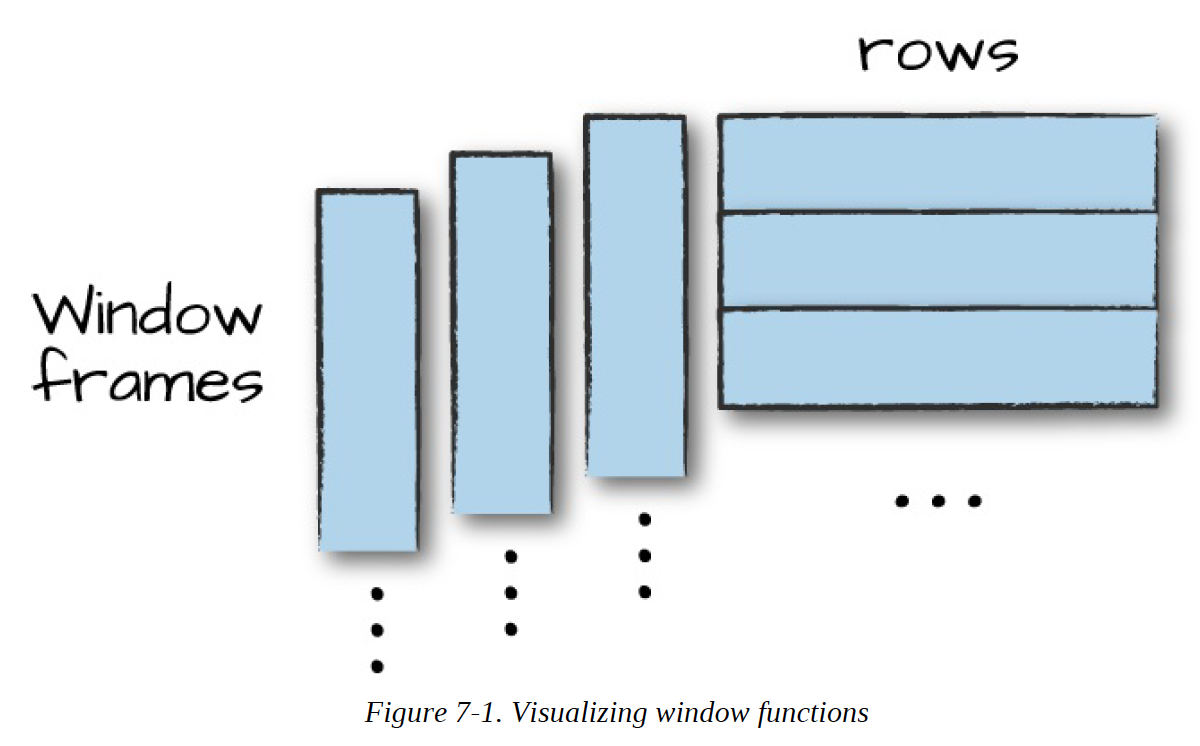
To demonstrate, we will add a date column that will convert our invoice date into a column that
contains only date information (not time information, too):

In [19]:
from pyspark.sql.functions import col, to_date
dfWithDate = df.withColumn("date", to_date(col("InvoiceDate"), "MM/d/yyyy H:mm"))
dfWithDate.createOrReplaceTempView("dfWithDate")

The first step to a window function is to create a window specification. Note that the partition
by is unrelated to the partitioning scheme concept that we have covered thus far. It’s just a
similar concept that describes how we will be breaking up our group. The ordering determines
the ordering within a given partition, and, finally, the frame specification (the rowsBetween
statement) states which rows will be included in the frame based on its reference to the current
input row. In the following example, we look at all previous rows up to the current row:

In [20]:
from pyspark.sql.window import Window
from pyspark.sql.functions import desc
windowSpec = Window\
.partitionBy("CustomerId", "date")\
.orderBy(desc("Quantity"))\
.rowsBetween(Window.unboundedPreceding, Window.currentRow)

Now we want to use an aggregation function to learn more about each specific customer. An
example might be establishing the maximum purchase quantity over all time. To answer this, we
use the same aggregation functions that we saw earlier by passing a column name or expression.
In addition, we indicate the window specification that defines to which frames of data this
function will apply:

In [21]:
from pyspark.sql.functions import max
maxPurchaseQuantity = max(col("Quantity")).over(windowSpec)

You will notice that this returns a column (or expressions). We can now use this in a DataFrame
select statement. Before doing so, though, we will create the purchase quantity rank. To do that
we use the dense_rank function to determine which date had the maximum purchase quantity
for every customer. We use dense_rank as opposed to rank to avoid gaps in the ranking
sequence when there are tied values (or in our case, duplicate rows):

In [22]:
from pyspark.sql.functions import dense_rank, rank
purchaseDenseRank = dense_rank().over(windowSpec)
purchaseRank = rank().over(windowSpec)

This also returns a column that we can use in select statements. Now we can perform a select to
view the calculated window values:

In [23]:
from pyspark.sql.functions import col

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

dfWithDate.where("CustomerId IS NOT NULL").orderBy("CustomerId")\
.select(
col("CustomerId"),
col("date"),
col("Quantity"),
purchaseRank.alias("quantityRank"),
purchaseDenseRank.alias("quantityDenseRank"),
maxPurchaseQuantity.alias("maxPurchaseQuantity")).show()
#-- in SQL
#SELECT CustomerId, date, Quantity,
            #rank(Quantity) OVER (PARTITION BY CustomerId, date
            #ORDER BY Quantity DESC NULLS LAST
            #ROWS BETWEEN
            #UNBOUNDED PRECEDING AND
            #CURRENT ROW) as rank,
#dense_rank(Quantity) OVER (PARTITION BY CustomerId, date
            #ORDER BY Quantity DESC NULLS LAST
            #ROWS BETWEEN
            #UNBOUNDED PRECEDING AND
            #CURRENT ROW) as dRank,
#max(Quantity) OVER (PARTITION BY CustomerId, date
            #ORDER BY Quantity DESC NULLS LAST
            #ROWS BETWEEN
            #UNBOUNDED PRECEDING AND
            #CURRENT ROW) as maxPurchase
            #FROM dfWithDate WHERE CustomerId IS NOT NULL ORDER BY CustomerId

+----------+----------+--------+------------+-----------------+-------------------+
|CustomerId|      date|Quantity|quantityRank|quantityDenseRank|maxPurchaseQuantity|
+----------+----------+--------+------------+-----------------+-------------------+
|     12346|2011-01-18|   74215|           1|                1|              74215|
|     12346|2011-01-18|  -74215|           2|                2|              74215|
|     12347|2010-12-07|      36|           1|                1|                 36|
|     12347|2010-12-07|      30|           2|                2|                 36|
|     12347|2010-12-07|      24|           3|                3|                 36|
|     12347|2010-12-07|      12|           4|                4|                 36|
|     12347|2010-12-07|      12|           4|                4|                 36|
|     12347|2010-12-07|      12|           4|                4|                 36|
|     12347|2010-12-07|      12|           4|                4|             

# Grouping Sets
Thus far in this chapter, we’ve seen simple group-by expressions that we can use to aggregate on
a set of columns with the values in those columns. However, sometimes we want something a bit
more complete—an aggregation across multiple groups. We achieve this by using grouping sets.
Grouping sets are a low-level tool for combining sets of aggregations together. They give you the
ability to create arbitrary aggregation in their group-by statements.
Let’s work through an example to gain a better understanding. Here, we would like to get the
total quantity of all stock codes and customers. To do so, we’ll use the following SQL
expression:

1. Grouping Sets: Used to perform aggregations across multiple groups. Grouping sets are a low-level tool for combining sets of aggregations together. They give you the ability to create arbitrary aggregation in their group-by statements.

2. Grouping sets depend on null values for aggregation levels. If you do not filter-out null values, you will get incorrect results. This applies to cubes, rollups, and grouping sets.

3. The GROUPING SETS operator is only available in SQL. To perform the same in DataFrames, you use the rollup and cube operators—which allow us to get the same results.
 
4. To include the total number of items, regardless of customer or stock code, we simply specify that we would like to aggregate at that level, as well, in our grouping set. (as shown in next example) . This is, effectively, the union of several different groupings together

In [27]:
# in Python
dfNoNull = dfWithDate.drop()
dfNoNull.createOrReplaceTempView("dfNoNull")

#-- in SQL
spark.sql("""SELECT CustomerId, stockCode, sum(Quantity) FROM dfNoNull
GROUP BY customerId, stockCode
ORDER BY CustomerId DESC, stockCode DESC""").show()

+----------+---------+-------------+
|CustomerId|stockCode|sum(Quantity)|
+----------+---------+-------------+
|     18287|    85173|           48|
|     18287|   85040A|           48|
|     18287|   85039B|          120|
|     18287|   85039A|           96|
|     18287|    84920|            4|
|     18287|    84584|            6|
|     18287|   84507C|            6|
|     18287|   72351B|           24|
|     18287|   72351A|           24|
|     18287|   72349B|           60|
|     18287|    47422|           24|
|     18287|    47421|           48|
|     18287|    35967|           36|
|     18287|    23445|           20|
|     18287|    23378|           24|
|     18287|    23376|           48|
|     18287|    23310|           36|
|     18287|    23274|           12|
|     18287|    23272|           12|
|     18287|    23269|           36|
+----------+---------+-------------+
only showing top 20 rows



You can do the exact same thing by using a grouping set:

In [28]:
#-- in SQL
spark.sql('''SELECT CustomerId, stockCode, sum(Quantity) FROM dfNoNull
GROUP BY customerId, stockCode GROUPING SETS((customerId, stockCode))
ORDER BY CustomerId DESC, stockCode DESC''').show()

+----------+---------+-------------+
|customerId|stockCode|sum(Quantity)|
+----------+---------+-------------+
|     18287|    85173|           48|
|     18287|   85040A|           48|
|     18287|   85039B|          120|
|     18287|   85039A|           96|
|     18287|    84920|            4|
|     18287|    84584|            6|
|     18287|   84507C|            6|
|     18287|   72351B|           24|
|     18287|   72351A|           24|
|     18287|   72349B|           60|
|     18287|    47422|           24|
|     18287|    47421|           48|
|     18287|    35967|           36|
|     18287|    23445|           20|
|     18287|    23378|           24|
|     18287|    23376|           48|
|     18287|    23310|           36|
|     18287|    23274|           12|
|     18287|    23272|           12|
|     18287|    23269|           36|
+----------+---------+-------------+
only showing top 20 rows



Simple enough, but what if you also want to include the total number of items, regardless of
customer or stock code? With a conventional group-by statement, this would be impossible. But,
it’s simple with grouping sets: we simply specify that we would like to aggregate at that level, as
well, in our grouping set. This is, effectively, the union of several different groupings together:

In [29]:
#-- in SQL
spark.sql('''SELECT CustomerId, stockCode, sum(Quantity) FROM dfNoNull
GROUP BY customerId, stockCode GROUPING SETS((customerId, stockCode),())
ORDER BY CustomerId DESC, stockCode DESC''').show()

+----------+---------+-------------+
|customerId|stockCode|sum(Quantity)|
+----------+---------+-------------+
|     18287|    85173|           48|
|     18287|   85040A|           48|
|     18287|   85039B|          120|
|     18287|   85039A|           96|
|     18287|    84920|            4|
|     18287|    84584|            6|
|     18287|   84507C|            6|
|     18287|   72351B|           24|
|     18287|   72351A|           24|
|     18287|   72349B|           60|
|     18287|    47422|           24|
|     18287|    47421|           48|
|     18287|    35967|           36|
|     18287|    23445|           20|
|     18287|    23378|           24|
|     18287|    23376|           48|
|     18287|    23310|           36|
|     18287|    23274|           12|
|     18287|    23272|           12|
|     18287|    23269|           36|
+----------+---------+-------------+
only showing top 20 rows



The GROUPING SETS operator is only available in SQL. To perform the same in DataFrames, you
use the rollup and cube operators—which allow us to get the same results. Let’s go through
those.
## Rollups
Thus far, we’ve been looking at explicit groupings. When we set our grouping keys of multiple
columns, Spark looks at those as well as the actual combinations that are visible in the dataset. A
rollup is a multidimensional aggregation that performs a variety of group-by style calculations
for us.

Let’s create a rollup that looks across time (with our new Date column) and space (with the
Country column) and creates a new DataFrame that includes the grand total over all dates, the
grand total for each date in the DataFrame, and the subtotal for each country on each date in the
DataFrame:

In [30]:
rolledUpDF = dfNoNull.rollup("Date", "Country").agg(sum("Quantity"))\
.selectExpr("Date", "Country", "`sum(Quantity)` as total_quantity")\
.orderBy("Date")
rolledUpDF.show()

+----------+--------------+--------------+
|      Date|       Country|total_quantity|
+----------+--------------+--------------+
|      null|          null|       5176450|
|2010-12-01|          null|         26814|
|2010-12-01|     Australia|           107|
|2010-12-01|        France|           449|
|2010-12-01|United Kingdom|         23949|
|2010-12-01|          EIRE|           243|
|2010-12-01|        Norway|          1852|
|2010-12-01|   Netherlands|            97|
|2010-12-01|       Germany|           117|
|2010-12-02|       Germany|           146|
|2010-12-02|          EIRE|             4|
|2010-12-02|          null|         21023|
|2010-12-02|United Kingdom|         20873|
|2010-12-03|        Poland|           140|
|2010-12-03|        France|           239|
|2010-12-03|       Germany|           170|
|2010-12-03|      Portugal|            65|
|2010-12-03|         Spain|           400|
|2010-12-03|   Switzerland|           110|
|2010-12-03|       Belgium|           528|
+----------

Now where you see the null values is where you’ll find the grand totals. A null in both rollup
columns specifies the grand total across both of those columns:

In [31]:
rolledUpDF.where("Country IS NULL").show()
rolledUpDF.where("Date IS NULL").show()

+----------+-------+--------------+
|      Date|Country|total_quantity|
+----------+-------+--------------+
|      null|   null|       5176450|
|2010-12-01|   null|         26814|
|2010-12-02|   null|         21023|
|2010-12-03|   null|         14830|
|2010-12-05|   null|         16395|
|2010-12-06|   null|         21419|
|2010-12-07|   null|         24995|
|2010-12-08|   null|         22741|
|2010-12-09|   null|         18431|
|2010-12-10|   null|         20297|
|2010-12-12|   null|         10565|
|2010-12-13|   null|         17623|
|2010-12-14|   null|         20098|
|2010-12-15|   null|         18229|
|2010-12-16|   null|         29632|
|2010-12-17|   null|         16069|
|2010-12-19|   null|          3795|
|2010-12-20|   null|         14965|
|2010-12-21|   null|         15467|
|2010-12-22|   null|          3192|
+----------+-------+--------------+
only showing top 20 rows

+----+-------+--------------+
|Date|Country|total_quantity|
+----+-------+--------------+
|null|   null|      

## Cube
A cube takes the rollup to a level deeper. Rather than treating elements hierarchically, a cube
does the same thing across all dimensions. This means that it won’t just go by date over the
entire time period, but also the country. To pose this as a question again, can you make a table
that includes the following?
1. The total across all dates and countries
2. The total for each date across all countries
3. The total for each country on each date
4. The total for each country across all dates

The method call is quite similar, but instead of calling rollup, we call cube:

In [32]:
from pyspark.sql.functions import sum
dfNoNull.cube("Date", "Country").agg(sum(col("Quantity")))\
.select("Date", "Country", "sum(Quantity)").orderBy("Date").show()

+----+--------------------+-------------+
|Date|             Country|sum(Quantity)|
+----+--------------------+-------------+
|null|               Japan|        25218|
|null|           Australia|        83653|
|null|            Portugal|        16180|
|null|             Germany|       117448|
|null|                 RSA|          352|
|null|           Hong Kong|         4769|
|null|              Cyprus|         6317|
|null|         Unspecified|         3300|
|null|United Arab Emirates|          982|
|null|                null|      5176450|
|null|     Channel Islands|         9479|
|null|             Finland|        10666|
|null|             Denmark|         8188|
|null|               Spain|        26824|
|null|             Lebanon|          386|
|null|  European Community|          497|
|null|           Singapore|         5234|
|null|              Norway|        19247|
|null|      Czech Republic|          592|
|null|                 USA|         1034|
+----+--------------------+-------

This is a quick and easily accessible summary of nearly all of the information in our table, and
it’s a great way to create a quick summary table that others can use later on.
## Grouping Metadata
Sometimes when using cubes and rollups, you want to be able to query the aggregation levels so
that you can easily filter them down accordingly. We can do this by using the grouping_id,
which gives us a column specifying the level of aggregation that we have in our result set. The
query in the example that follows returns four distinct grouping IDs:
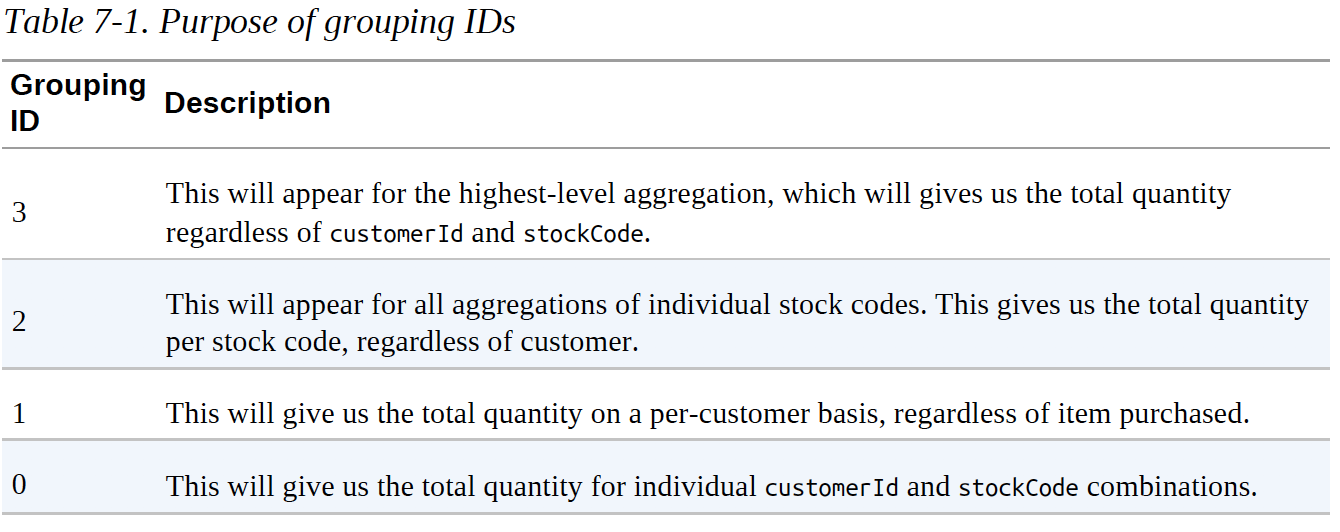
This is a bit abstract, so it’s well worth trying out to understand the behavior yourself:

In [34]:
#// in Scala
#import org.apache.spark.sql.functions.{grouping_id, sum, expr}
#dfNoNull.cube("customerId", "stockCode").agg(grouping_id(), sum("Quantity"))
#.orderBy(expr("grouping_id()").desc)
#.show()

## Pivot
Pivots make it possible for you to convert a row into a column. For example, in our current data
we have a Country column. With a pivot, we can aggregate according to some function for each
of those given countries and display them in an easy-to-query way:

In [35]:
pivoted = dfWithDate.groupBy("date").pivot("Country").sum()

This DataFrame will now have a column for every combination of country, numeric variable,
and a column specifying the date. For example, for USA we have the following columns:
USA_sum(Quantity), USA_sum(UnitPrice), USA_sum(CustomerID). This represents one for
each numeric column in our dataset (because we just performed an aggregation over all of them).
Here’s an example query and result from this data:

In [45]:
pivoted.where("date > '2011-12-05'").select("date", "USA_sum(CAST(Quantity AS BIGINT))").show()

+----------+---------------------------------+
|      date|USA_sum(CAST(Quantity AS BIGINT))|
+----------+---------------------------------+
|2011-12-06|                             null|
|2011-12-09|                             null|
|2011-12-08|                             -196|
|2011-12-07|                             null|
+----------+---------------------------------+



# Conclusion
This chapter walked through the different types and kinds of aggregations that you can perform
in Spark. You learned about simple grouping-to window functions as well as rollups and cubes.
Chapter 8 discusses how to perform joins to combine different data sources together.